## 1. Ответы на вопросы:

1. Предложите новый метод инициализации центроидов кластеров для алгоритма K-средних. Перечислите преимущества и недостатки методов подделки, случайного разбиения и ваших собственных методов инициализации

Методы инициализации — это способы выбора начальных центроидов для алгоритма K-средних (K-Means)

| Метод                              | Описание                                                                                                                        | Преимущества                                                      | Недостатки                                                         |
|-----------------------------------|---------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------|-------------------------------------------------------------------|
| **Метод подделки (Forgy)**        | Случайный выбор K точек из данных, которые становятся начальными центроидами.                                                   | Простой и быстрый; центры принадлежат данным.                    | Возможен выбор близко расположенных центров; нестабильность; чувствителен к выбросам. |
| **Случайное разбиение**            | Случайное распределение всех точек по K кластерам, затем вычисление центров как средних точек каждого кластера.                  | Центры отражают распределение данных; простой способ.            | Неровные, неравномерные кластеры; нестабильность; плохая сходимость.              |
| **K-Means++**                     | Первый центр выбирается случайно, каждый следующий — с вероятностью, пропорциональной квадрату расстояния до ближайшего центра. | Высокое качество кластеров; ускоряет сходимость; снижает близость центров. | Сложнее реализации; не учитывает плотность данных; может выбрать центр в разреженной области. |
| **Плотностно-отдалённый выбор (новый)** | Выбор первой центроиды из самой плотной области, последующих — максимально удалённых от выбранных и в плотных областях.           | Учитывает плотность; равномерное покрытие; устойчив к выбросам. | Вычислительно затратен; требует настройки параметров; сложен в реализации.       |

2. Опишите, как можно использовать кластеризацию для ускорения модели KNN. Подсказка: что такое kd-tree?

Алгоритм KNN (K-ближайших соседей) для каждого нового объекта ищет в обучающей выборке K ближайших точек (соседей) по некоторой метрике (например, евклидово расстояние). На больших данных поиск всех соседей перебором становится очень дорогим по времени

Ускорение через кластеризацию:
1. Разбиваем обучающую выборку на кластеры (например, с помощью K-Means).
2. При поиске ближайших соседей для нового объекта:
    - Сначала определяем, к какому кластеру он ближе всего (по центроиду).
    - Затем ищем ближайших соседей только внутри этого кластера или нескольких ближайших кластеров.

Это сильно уменьшает количество точек, по которым нужно считать расстояния, ускоряя поиск

## 2. Введение: предварительная обработка данных


In [221]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
from sklearn.model_selection import GridSearchCV
from collections import Counter
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [222]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [223]:
def replace_features(x):
    return x.replace('"', '').replace('[', '').replace(']', '').replace("'", '').replace(' ', '')

train['replace_features'] = train['features'].apply(replace_features)
test['replace_features'] = test['features'].apply(replace_features)

In [224]:
features_list = []
for feature in train['replace_features']:
    for f in feature.split(','):
        features_list.append(f)
        
cnt = Counter(features_list)
cnt.most_common(21)

[('Elevator', 19059),
 ('HardwoodFloors', 17317),
 ('CatsAllowed', 17229),
 ('DogsAllowed', 16134),
 ('Doorman', 15353),
 ('Dishwasher', 15024),
 ('NoFee', 13369),
 ('LaundryinBuilding', 12090),
 ('FitnessCenter', 9717),
 ('Pre-War', 6762),
 ('LaundryinUnit', 6294),
 ('RoofDeck', 4774),
 ('OutdoorSpace', 3816),
 ('DiningRoom', 3677),
 ('HighSpeedInternet', 3150),
 ('', 2313),
 ('Balcony', 2181),
 ('SwimmingPool', 2012),
 ('LaundryInBuilding', 1941),
 ('NewConstruction', 1859),
 ('Terrace', 1602)]

In [225]:
most_common_features = [i[0] for i in cnt.most_common(21) if i[0] != '']
print(most_common_features)

['Elevator', 'HardwoodFloors', 'CatsAllowed', 'DogsAllowed', 'Doorman', 'Dishwasher', 'NoFee', 'LaundryinBuilding', 'FitnessCenter', 'Pre-War', 'LaundryinUnit', 'RoofDeck', 'OutdoorSpace', 'DiningRoom', 'HighSpeedInternet', 'Balcony', 'SwimmingPool', 'LaundryInBuilding', 'NewConstruction', 'Terrace']


In [226]:
for feature in most_common_features:
    train[feature] = train['replace_features'].str.contains(feature).astype('int')
    test[feature] = test['replace_features'].str.contains(feature).astype('int')
 
features = ['bathrooms',  'bedrooms', 'interest_level'] + most_common_features
target = 'price'

train_X = train[features]
train_y = train[target]

test_X = test[features]
test_y = test[target]

## 3. KMeans


| Метрика         | Что показывает                          | Хорошие значения        |
|-----------------|------------------------------------------|--------------------------|
| inertia_        | Сумма квадратов расстояний до центров    | Чем меньше — тем лучше  |
| silhouette_score | Насколько кластеры "раздельные и плотные" | Ближе к 1 — тем лучше   |


In [227]:
# Реализация KMeans
def kmeans(X, n_clusters=10, n_init=10, max_iter=300, tol=1e-4, random_state=None):
    # Установка зерна генератора случайных чисел для воспроизводимости
    if random_state is not None:
        np.random.seed(random_state)

    n_samples = X.shape[0]  # Количество объектов в выборке
    best_inertia = np.inf   # Лучшее значение инерции (сначала бесконечность)
    best_labels = None      # Лучшие метки кластеров (будут обновлены позже)

    # Повторяем алгоритм n_init раз с разными случайными инициализациями
    for init_no in range(n_init):
        # Случайно выбираем n_clusters точек как начальные центроиды
        initial_indices = np.random.choice(n_samples, n_clusters, replace=False)
        centroids = X[initial_indices]  # Центроиды — выбранные точки

        # Основной цикл кластеризации (максимум max_iter шагов)
        for _ in range(max_iter):
            # Вычисляем расстояния от каждой точки до каждого центроида
            # Результат: матрица (n_samples, n_clusters)
            distances = np.linalg.norm(X[:, None] - centroids, axis=2)

            # Для каждой точки находим индекс ближайшего центроида
            labels = np.argmin(distances, axis=1)

            # Обновляем центроиды — берем среднее всех точек в кластере
            new_centroids = np.array([
                X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
                for i in range(n_clusters)
            ])

            # Проверка на сходимость: если центроиды почти не изменились — выходим
            if np.linalg.norm(new_centroids - centroids) < tol:
                break

            # Обновляем центроиды для следующей итерации
            centroids = new_centroids

        # После завершения итераций считаем инерцию (сумма квадратов расстояний до центров)
        inertia = np.sum((X - centroids[labels]) ** 2)

        # Если это наименьшая инерция из всех запусков — сохраняем результат
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels.copy()

    # Возвращаем метки и лучшую (наименьшую) инерцию
    return best_labels, best_inertia

In [228]:
labels, inertia = kmeans(train[['latitude', 'longitude']].values, n_clusters=30, n_init=10, random_state=0)
print("Искажение (Inertia):", inertia)
sil_score = silhouette_score(train[['latitude', 'longitude']], labels)
print("Оценка силуэта:", sil_score)

Искажение (Inertia): 21.30187010429968
Оценка силуэта: 0.4290430650518788


In [229]:
k_means = KMeans(n_clusters=30, n_init=10, random_state=0)
k_means.fit(train[['latitude', 'longitude']])

train_pred = k_means.predict(train[['latitude', 'longitude']])
test_pred = k_means.predict(test[['latitude', 'longitude']])

# Искажение
print("Искажение (Inertia):", k_means.inertia_)

# Оценка силуэта
sil_score = silhouette_score(train[['latitude', 'longitude']], k_means.labels_)
print("Оценка силуэта:", sil_score)

Искажение (Inertia): 4.428455045004587
Оценка силуэта: 0.4685976674927788


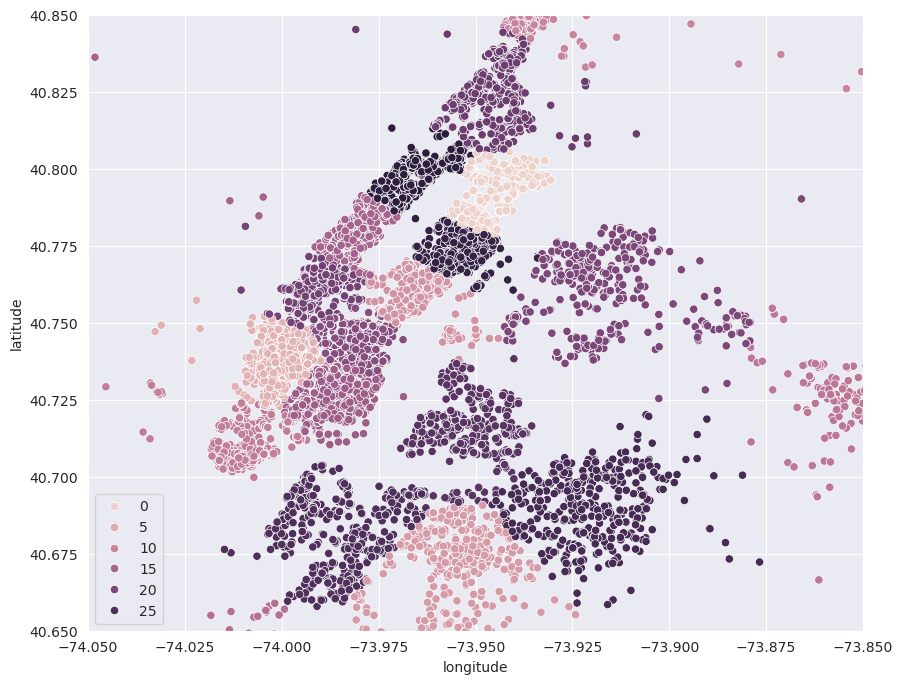

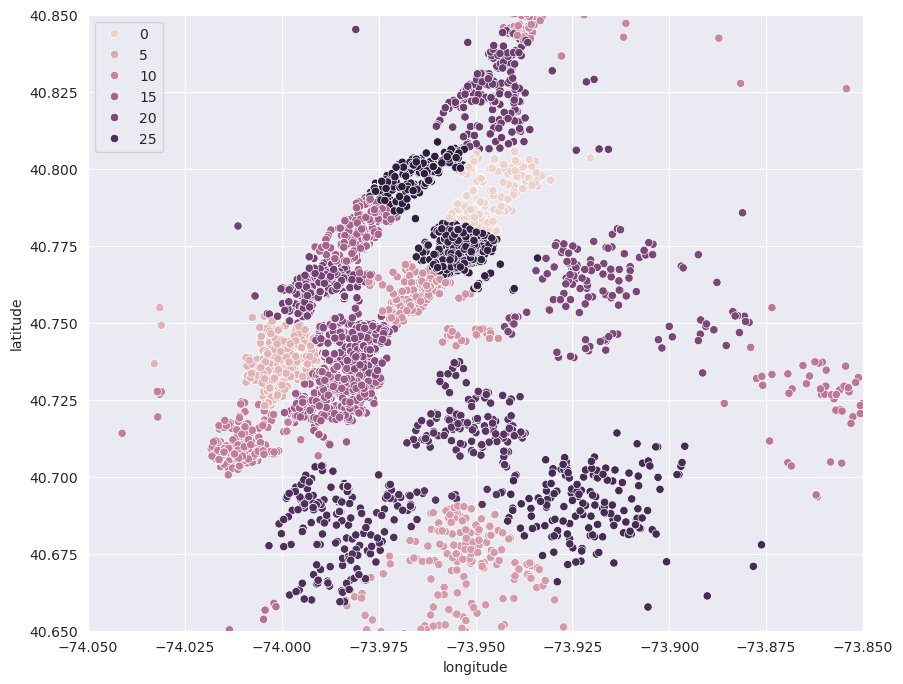

In [230]:
def show_scatterplot(x, y, hue):
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(x=x, y=y, hue=hue)
    scatter.set(xlim=(-74.05,-73.85))
    scatter.set(ylim=(40.65,40.85))
    plt.show()
    
show_scatterplot(x=train['longitude'], y=train['latitude'], hue=train_pred)
show_scatterplot(x=test['longitude'], y=test['latitude'], hue=test_pred)

In [ ]:
mms = MinMaxScaler()
lasso = Lasso(random_state=42)

df_metrics = pd.DataFrame()
def print_metrics(train, test, model):
    global df_metrics
    train_x_mms = mms.fit_transform(train)
    test_x_mms = mms.transform(test)

    lasso.fit(train_x_mms, train_y)

    train_predict = lasso.predict(train_x_mms)
    test_predict = lasso.predict(test_x_mms)

    metrics_dict = {
        'Model': model,
        'Train MAE': mean_absolute_error(train_y, train_predict),
        'Test MAE': mean_absolute_error(test_y, test_predict),
        'Train RMSE': mean_squared_error(train_y, train_predict)**0.5,
        'Test RMSE': mean_squared_error(test_y, test_predict)**0.5,
        'Train R2': r2_score(train_y, train_predict),
        'Test R2': r2_score(test_y, test_predict)
    }

    # Вывод на экран
    for k, v in metrics_dict.items():
        print(f"{k}: {v}")

    # Сохранение в DataFrame
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_dict])], ignore_index=True)

    return lasso.coef_

In [232]:
coef_base = print_metrics(train_X, test_X, 'Base Lasso') # До добавления признаков

Model: Base Lasso
Train MAE: 690.6967986092563
Test MAE: 679.4449600453096
Train RMSE: 1005.1510196355724
Test RMSE: 972.0741648306383
Train R2: 0.6056108592809226
Test R2: 0.6015130187847189


In [233]:
train_cluster_X = train_X.copy()
train_cluster_X['cluster'] = train_pred
test_cluster_X = test_X.copy()
test_cluster_X['cluster'] = test_pred

coef_new = print_metrics(train_cluster_X, test_cluster_X, 'KMeans Lasso')

Model: KMeans Lasso
Train MAE: 686.3177767335206
Test MAE: 673.5317146243619
Train RMSE: 1000.1035762737013
Test RMSE: 966.2285535504744
Train R2: 0.6095618252414212
Test R2: 0.6062912468276374


In [234]:
features_cluster = features + ['cluster']
feature_importance = pd.DataFrame({
    'feature': features_cluster,
    'coef': abs(coef_new)
})
feature_importance = feature_importance.sort_values('coef', ascending=True)
feature_importance

,feature,coef
5,CatsAllowed,0.000000
18,Balcony,0.000000
19,SwimmingPool,31.531047
21,NewConstruction,35.691391
15,OutdoorSpace,41.925209
12,Pre-War,52.415115
6,DogsAllowed,66.401012
9,NoFee,78.722619
14,RoofDeck,106.569420
4,HardwoodFloors,109.925304


## 4. DBSCAN


In [235]:
from collections import deque
from sklearn.neighbors import BallTree

# Реализация DBSCAN
def dbscan_tree(X, eps, min_samples):
    n = X.shape[0]  # Количество точек в выборке

    # Изначально всем точкам присваиваем метку -1 (шум)
    labels = np.full(n, -1)

    cluster_id = 0  # Счётчик кластеров
    visited = np.zeros(n, dtype=bool)  # Массив, отслеживающий посещённые точки

    # Строим дерево для быстрого поиска соседей
    tree = BallTree(X)

    # Перебираем все точки
    for i in range(n):
        if visited[i]:
            continue  # Пропускаем уже обработанные точки

        visited[i] = True  # Отмечаем точку как посещённую

        # Ищем индексы всех соседей в пределах радиуса eps
        neighbors = tree.query_radius([X[i]], r=eps)[0]

        # Если соседей меньше, чем min_samples — точка считается шумом
        if len(neighbors) < min_samples:
            labels[i] = -1
        else:
            # Начинаем новый кластер
            labels[i] = cluster_id
            queue = deque(neighbors)  # Очередь для обхода плотной области

            # Обход всех точек в окрестности (и расширение кластера)
            while queue:
                j = queue.popleft()

                # Если точка j ещё не была посещена
                if not visited[j]:
                    visited[j] = True
                    # Ищем её соседей
                    local_neighbors = tree.query_radius([X[j]], r=eps)[0]
                    # Если она core-точка, добавляем её соседей в очередь
                    if len(local_neighbors) >= min_samples:
                        queue.extend(local_neighbors)

                # Если точка ещё не принадлежит никакому кластеру (была шумом)
                if labels[j] == -1:
                    labels[j] = cluster_id  # Назначаем её текущему кластеру

            # Переход к следующему кластеру
            cluster_id += 1

    return labels  # Возвращаем метки кластеров

In [236]:
train['train'] = 1
test['train'] = 0
full_df = pd.concat([train, test]).reset_index(drop=True)

In [237]:
labels = dbscan_tree(full_df[['latitude', 'longitude']].values, eps=0.001, min_samples=5)
# Оценка силуэта
sil_score = silhouette_score(full_df[['latitude', 'longitude']], labels)
print("Оценка силуэта:", sil_score)

Оценка силуэта: -0.17213582938345792


In [238]:
dbscan = DBSCAN(eps=0.001, min_samples=5)
pred = dbscan.fit_predict(full_df[['latitude', 'longitude']])

# Оценка силуэта
sil_score = silhouette_score(full_df[['latitude', 'longitude']], dbscan.labels_)
print("Оценка силуэта:", sil_score)

Оценка силуэта: -0.17213582938345792


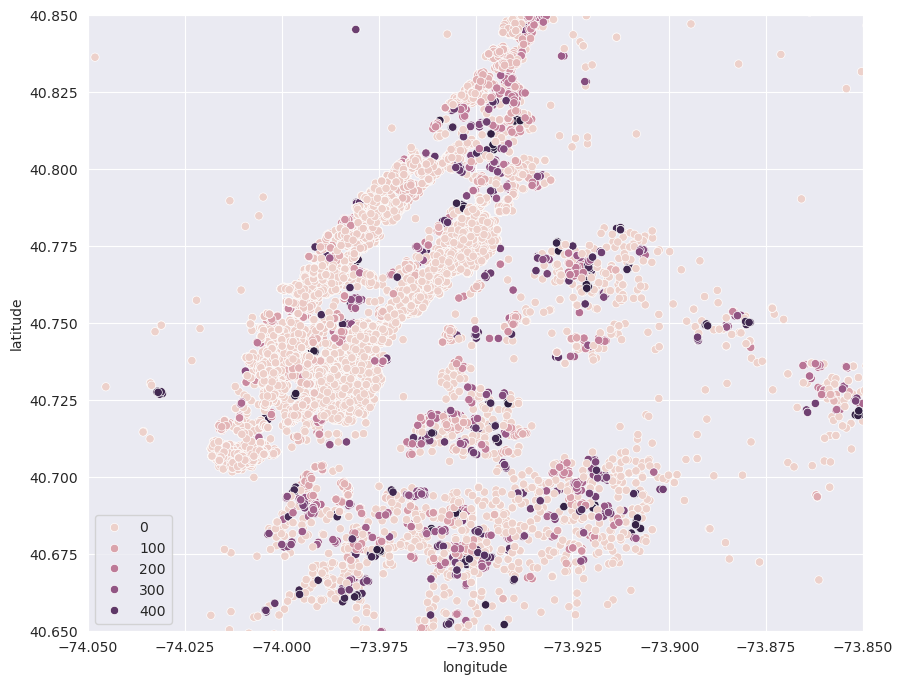

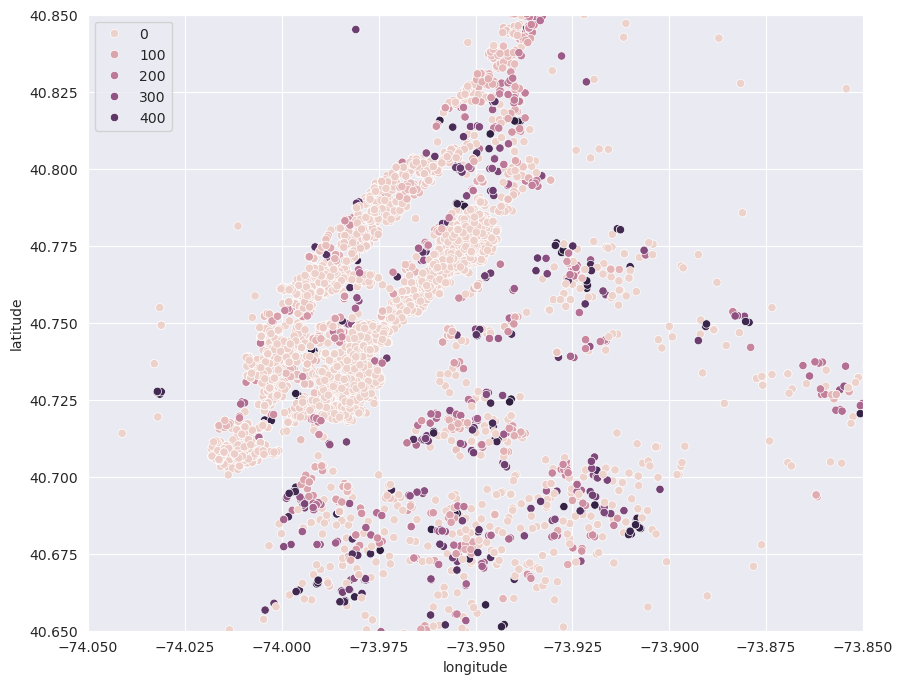

In [239]:
train_pred_dbscan = pred[:train.shape[0]]
test_pred_dbscan = pred[train.shape[0]:]

show_scatterplot(x=train['longitude'], y=train['latitude'], hue=train_pred_dbscan)
show_scatterplot(x=test['longitude'], y=test['latitude'], hue=test_pred_dbscan)

In [240]:
train_dbscan_X = train_X.copy()
train_dbscan_X['cluster'] = train_pred_dbscan
test_dbscan_X = test_X.copy()
test_dbscan_X['cluster'] = test_pred_dbscan

coef_dbscan = print_metrics(train_dbscan_X, test_dbscan_X, 'DBSCAN Lasso')

Model: DBSCAN Lasso
Train MAE: 680.7358264358159
Test MAE: 668.2765562406203
Train RMSE: 993.8243951380069
Test RMSE: 962.0399456220832
Train R2: 0.614449190422317
Test R2: 0.6096973088547092


In [241]:
features_cluster = features + ['cluster']
feature_importance_dbscan = pd.DataFrame({
    'feature': features_cluster,
    'coef': abs(coef_dbscan)
})
feature_importance_dbscan = feature_importance_dbscan.sort_values('coef', ascending=True)
feature_importance_dbscan

,feature,coef
18,Balcony,0.000000
5,CatsAllowed,0.000000
21,NewConstruction,2.513493
19,SwimmingPool,32.178338
15,OutdoorSpace,43.032411
12,Pre-War,57.459528
6,DogsAllowed,76.446586
9,NoFee,86.302644
14,RoofDeck,105.510730
8,Dishwasher,120.562048


## 5. AgglomerativeClustering


Agglomerative silhouette: 0.422353910468654


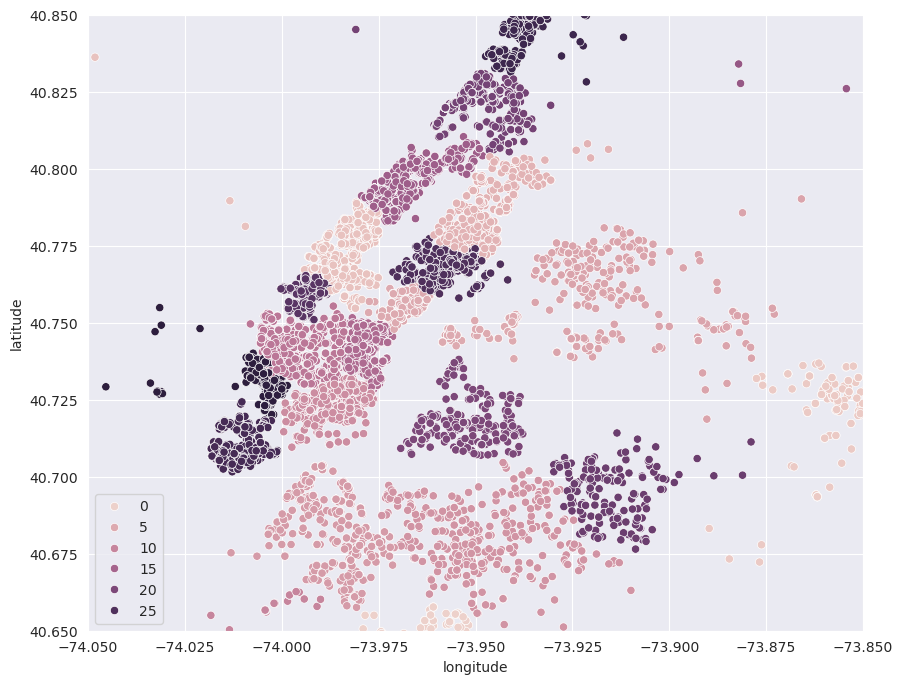

In [257]:
# AgglomerativeClustering — это алгоритм для маленьких выборок
data_X = pd.concat([train_X, test_X]).reset_index(drop=True)
data_y = pd.concat([train_y, test_y]).reset_index(drop=True)
sample_idx = data_X.sample(20000, random_state=42).index
sample_data = data_X.loc[sample_idx]
sample_target = data_y.loc[sample_idx]

sample_cluster = full_df.loc[sample_idx]
sample = sample_cluster[['latitude', 'longitude']]
ac = AgglomerativeClustering(n_clusters=30)
ac.fit(sample)
labels = ac.labels_

sil_score = silhouette_score(sample, labels)
print("Agglomerative silhouette:", sil_score)
show_scatterplot(x=sample['longitude'], y=sample['latitude'], hue=labels)

In [243]:
sample_data['cluster'] = labels
ac_train_X, ac_test_X, ac_train_y, ac_test_y = train_test_split(
    sample_data, sample_target, test_size=0.2, random_state=42
)

train_x_mms = mms.fit_transform(ac_train_X)
test_x_mms = mms.transform(ac_test_X)

lasso.fit(train_x_mms, ac_train_y)
ac_coef = lasso.coef_

train_predict = lasso.predict(train_x_mms)
test_predict = lasso.predict(test_x_mms)

metrics_dict = {
    'Model': 'AgglomerativeClustering Lasso',
    'Train MAE': mean_absolute_error(ac_train_y, train_predict),
    'Test MAE': mean_absolute_error(ac_test_y, test_predict),
    'Train RMSE': mean_squared_error(ac_train_y, train_predict)**0.5,
    'Test RMSE': mean_squared_error(ac_test_y, test_predict)**0.5,
    'Train R2': r2_score(ac_train_y, train_predict),
    'Test R2': r2_score(ac_test_y, test_predict)
}

# Вывод на экран
for k, v in metrics_dict.items():
    print(f"{k}: {v}")

# Сохранение в DataFrame
df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_dict])], ignore_index=True)

Model: AgglomerativeClustering Lasso
Train MAE: 686.3348635304171
Test MAE: 701.0048864173949
Train RMSE: 984.5113675596671
Test RMSE: 1061.840101968555
Train R2: 0.6092845880868997
Test R2: 0.5530496018238423


In [244]:
features_cluster = features + ['cluster']
feature_importance_ac = pd.DataFrame({
    'feature': features_cluster,
    'coef': abs(ac_coef)
})
feature_importance_ac = feature_importance_ac.sort_values('coef', ascending=True)
feature_importance_ac

,feature,coef
18,Balcony,7.109352
12,Pre-War,24.211143
5,CatsAllowed,25.277556
21,NewConstruction,35.170609
14,RoofDeck,57.072546
19,SwimmingPool,58.540043
15,OutdoorSpace,65.336824
23,cluster,71.707804
9,NoFee,80.613290
6,DogsAllowed,83.219098


## 6.GaussianMixture


In [245]:
gm = GaussianMixture(n_components=30)
gm.fit(train[['latitude', 'longitude']])

train_pred_gm = gm.predict(train[['latitude', 'longitude']])
test_pred_gm = gm.predict(test[['latitude', 'longitude']])

# Оценка силуэта
sil_score = silhouette_score(train[['latitude', 'longitude']], train_pred_gm)
print("Оценка силуэта:", sil_score)

Оценка силуэта: 0.4150793505936549


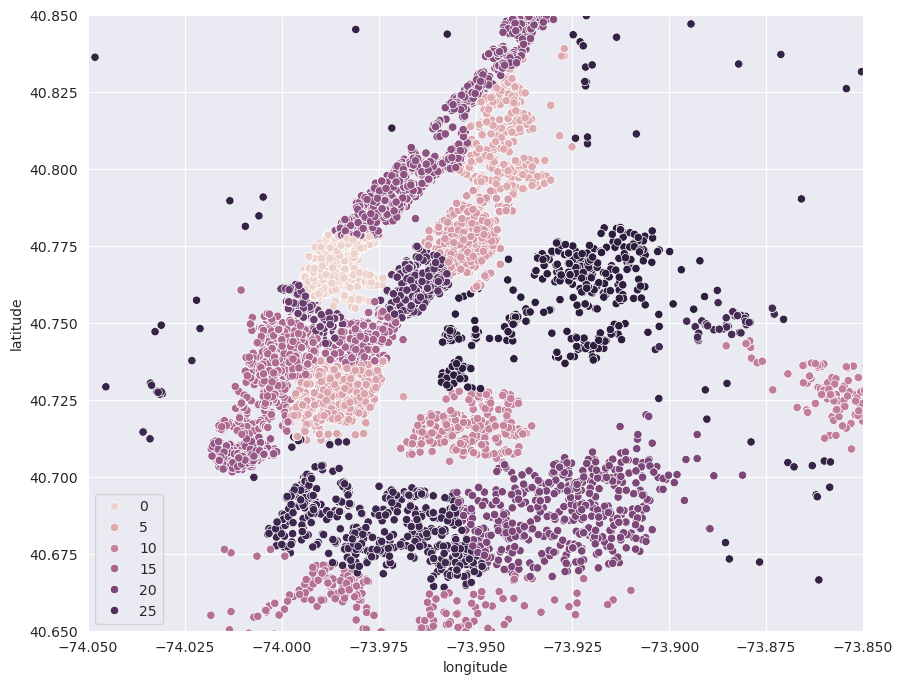

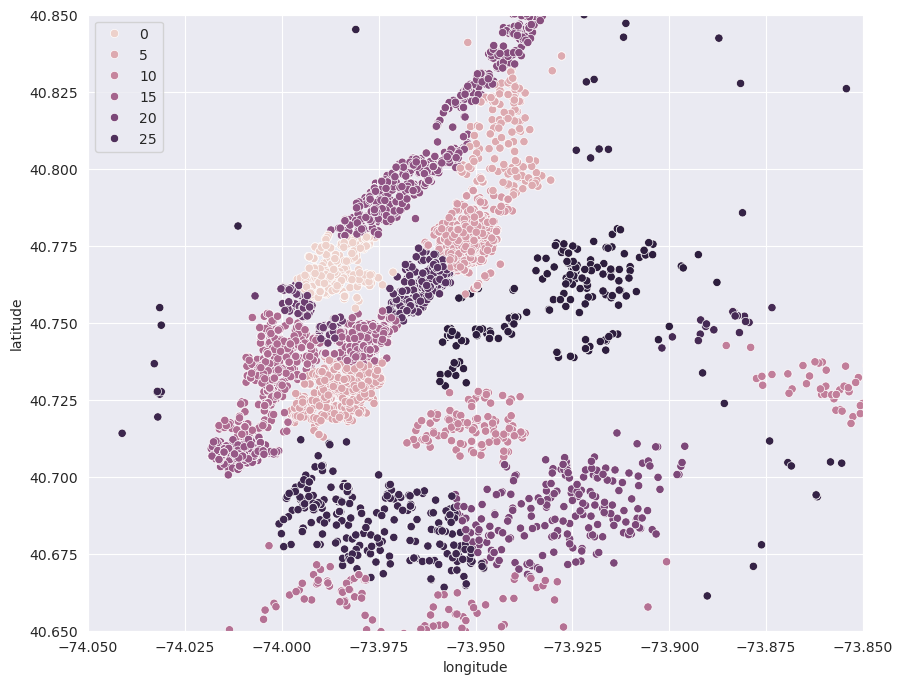

In [246]:
show_scatterplot(x=train['longitude'], y=train['latitude'], hue=train_pred_gm)
show_scatterplot(x=test['longitude'], y=test['latitude'], hue=test_pred_gm)

In [247]:
train_gm_X = train_X.copy()
train_gm_X['cluster'] = train_pred_gm
test_gm_X = test_X.copy()
test_gm_X['cluster'] = test_pred_gm

coef_gm = print_metrics(train_gm_X, test_gm_X, 'GaussianMixture Lasso')

Model: GaussianMixture Lasso
Train MAE: 687.2744672928798
Test MAE: 675.5133788754778
Train RMSE: 999.9951115699997
Test RMSE: 965.967690126171
Train R2: 0.6096465093991597
Test R2: 0.6065038059557162


In [248]:
features_cluster = features + ['cluster']
feature_importance_gm = pd.DataFrame({
    'feature': features_cluster,
    'coef': abs(coef_gm)
})
feature_importance_gm = feature_importance_gm.sort_values('coef', ascending=True)
feature_importance_gm

,feature,coef
5,CatsAllowed,0.000000
18,Balcony,0.000000
19,SwimmingPool,5.006262
21,NewConstruction,28.206646
15,OutdoorSpace,37.839222
12,Pre-War,44.261765
6,DogsAllowed,70.021901
9,NoFee,84.874364
14,RoofDeck,87.075260
4,HardwoodFloors,123.835210


## 7. New features


In [249]:
features_cluster = features + ['cluster']
def sort_features(coef):
    df = pd.DataFrame({
    'feature': features_cluster,
    'coef': abs(coef)
})
    df = df.sort_values('coef', ascending=True)
    print(df)

In [250]:
df_metrics

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2
0,Base Lasso,690.696799,679.444960,1005.151020,972.074165,0.605611,0.601513
1,KMeans Lasso,686.317777,673.531715,1000.103576,966.228554,0.609562,0.606291
2,DBSCAN Lasso,680.735826,668.276556,993.824395,962.039946,0.614449,0.609697
3,AgglomerativeClustering Lasso,686.334864,701.004886,984.511368,1061.840102,0.609285,0.553050
4,GaussianMixture Lasso,687.274467,675.513379,999.995112,965.967690,0.609647,0.606504


In [251]:
new_features = ['bathrooms',  'bedrooms', 'interest_level']

k_means = KMeans(n_clusters=30, n_init=10, random_state=0)
k_means.fit(train[new_features])

train_pred = k_means.predict(train[new_features])
test_pred = k_means.predict(test[new_features])

train_cluster_X = train_X.copy()
train_cluster_X['cluster'] = train_pred
test_cluster_X = test_X.copy()
test_cluster_X['cluster'] = test_pred

coef_new = print_metrics(train_cluster_X, test_cluster_X, 'KMeans Lasso 2')
sort_features(coef_new)

Model: KMeans Lasso 2
Train MAE: 686.8793035022787
Test MAE: 675.1799039372326
Train RMSE: 999.6315942360088
Test RMSE: 966.1112555617248
Train R2: 0.6099302597232312
Test R2: 0.6063868317523026
              feature          coef
18            Balcony      0.000000
5         CatsAllowed      0.000000
19       SwimmingPool     29.828515
15       OutdoorSpace     43.608001
21    NewConstruction     45.199261
12            Pre-War     45.909610
6         DogsAllowed     77.550685
9               NoFee     94.556936
4      HardwoodFloors     97.924689
14           RoofDeck    101.604885
22            Terrace    127.404874
8          Dishwasher    141.274772
16         DiningRoom    141.383714
20  LaundryInBuilding    161.127187
10  LaundryinBuilding    175.001933
3            Elevator    191.087359
11      FitnessCenter    208.915741
17  HighSpeedInternet    221.456895
13      LaundryinUnit    431.572907
7             Doorman    561.698838
23            cluster    696.947085
2      intere

In [252]:
dbscan = DBSCAN(eps=0.001, min_samples=5)
pred = dbscan.fit_predict(full_df[new_features])
train_pred_dbscan = pred[:train.shape[0]]
test_pred_dbscan = pred[train.shape[0]:]

train_dbscan_X = train_X.copy()
train_dbscan_X['cluster'] = train_pred_dbscan
test_dbscan_X = test_X.copy()
test_dbscan_X['cluster'] = test_pred_dbscan

coef_dbscan = print_metrics(train_dbscan_X, test_dbscan_X, 'DBSCAN Lasso 2')
sort_features(coef_dbscan)

Model: DBSCAN Lasso 2
Train MAE: 689.6788160169435
Test MAE: 678.3486969739881
Train RMSE: 1001.9337947387693
Test RMSE: 967.7447022930627
Train R2: 0.6081314913610923
Test R2: 0.605054708421739
              feature          coef
18            Balcony      0.000000
5         CatsAllowed      1.054282
19       SwimmingPool     29.616743
21    NewConstruction     42.701465
15       OutdoorSpace     43.508415
12            Pre-War     47.214902
6         DogsAllowed     74.585252
9               NoFee     95.366099
14           RoofDeck    100.880589
4      HardwoodFloors    106.346094
22            Terrace    123.974687
8          Dishwasher    135.974112
16         DiningRoom    141.300296
20  LaundryInBuilding    173.083110
10  LaundryinBuilding    179.971741
3            Elevator    195.495765
11      FitnessCenter    213.196616
17  HighSpeedInternet    219.571171
13      LaundryinUnit    436.044066
7             Doorman    566.270534
23            cluster    762.536097
2      intere

In [273]:
# AgglomerativeClustering — это алгоритм для маленьких выборок

sample = sample_cluster[new_features]
ac = AgglomerativeClustering(n_clusters=30)
ac.fit(sample)

labels = ac.labels_
sample_data['cluster'] = labels
ac_train_X, ac_test_X, ac_train_y, ac_test_y = train_test_split(
    sample_data, sample_target, test_size=0.2, random_state=42
)

train_x_mms = mms.fit_transform(ac_train_X)
test_x_mms = mms.transform(ac_test_X)

lasso.fit(train_x_mms, ac_train_y)

train_predict = lasso.predict(train_x_mms)
test_predict = lasso.predict(test_x_mms)

metrics_dict = {
    'Model': 'AgglomerativeClustering Lasso 2',
    'Train MAE': mean_absolute_error(ac_train_y, train_predict),
    'Test MAE': mean_absolute_error(ac_test_y, test_predict),
    'Train RMSE': mean_squared_error(ac_train_y, train_predict)**0.5,
    'Test RMSE': mean_squared_error(ac_test_y, test_predict)**0.5,
    'Train R2': r2_score(ac_train_y, train_predict),
    'Test R2': r2_score(ac_test_y, test_predict)
}

# Вывод на экран
for k, v in metrics_dict.items():
    print(f"{k}: {v}")

# Сохранение в DataFrame
df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_dict])], ignore_index=True)

ac_coef = lasso.coef_
sort_features(ac_coef)

Model: AgglomerativeClustering Lasso 2
Train MAE: 686.3203463385308
Test MAE: 700.6092001870475
Train RMSE: 984.7177305300687
Test RMSE: 1062.4630586662265
Train R2: 0.6091207755683956
Test R2: 0.5525250173445974
              feature         coef
18            Balcony     4.286234
12            Pre-War    24.287038
5         CatsAllowed    27.662458
21    NewConstruction    33.483866
23            cluster    43.908339
19       SwimmingPool    55.796002
14           RoofDeck    56.591184
15       OutdoorSpace    63.467410
9               NoFee    77.817351
6         DogsAllowed    86.782285
16         DiningRoom    95.170652
8          Dishwasher   120.389530
4      HardwoodFloors   135.528007
11      FitnessCenter   159.255088
22            Terrace   186.432479
10  LaundryinBuilding   189.682501
17  HighSpeedInternet   196.803061
20  LaundryInBuilding   212.667572
3            Elevator   218.846046
13      LaundryinUnit   433.971959
7             Doorman   582.053634
2      interest_l

In [274]:
gm = GaussianMixture(n_components=30)
gm.fit(train[new_features])

train_pred_gm = gm.predict(train[new_features])
test_pred_gm = gm.predict(test[new_features])

train_gm_X = train_X.copy()
train_gm_X['cluster'] = train_pred_gm
test_gm_X = test_X.copy()
test_gm_X['cluster'] = test_pred_gm

coef_gm = print_metrics(train_gm_X, test_gm_X, 'GaussianMixture Lasso 2')
sort_features(coef_gm)

Model: GaussianMixture Lasso 2
Train MAE: 685.8310725127733
Test MAE: 673.1970854047271
Train RMSE: 997.2429614357583
Test RMSE: 963.1150641467262
Train R2: 0.611792186030518
Test R2: 0.6088244633404282
              feature          coef
18            Balcony      0.000000
5         CatsAllowed      8.047709
19       SwimmingPool     27.730755
15       OutdoorSpace     39.169306
12            Pre-War     40.496529
21    NewConstruction     47.376571
6         DogsAllowed     84.554212
4      HardwoodFloors     89.702651
9               NoFee     94.965881
14           RoofDeck     96.620188
22            Terrace    126.878530
8          Dishwasher    140.528047
16         DiningRoom    142.631604
20  LaundryInBuilding    158.779272
10  LaundryinBuilding    171.519910
3            Elevator    189.456064
11      FitnessCenter    202.532564
17  HighSpeedInternet    212.912729
13      LaundryinUnit    428.566871
7             Doorman    563.335762
23            cluster    916.678609
2    

## 8. Scoring


In [275]:
df_metrics

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2
0,Base Lasso,690.696799,679.444960,1005.151020,972.074165,0.605611,0.601513
1,KMeans Lasso,686.317777,673.531715,1000.103576,966.228554,0.609562,0.606291
2,DBSCAN Lasso,680.735826,668.276556,993.824395,962.039946,0.614449,0.609697
3,AgglomerativeClustering Lasso,686.334864,701.004886,984.511368,1061.840102,0.609285,0.553050
4,GaussianMixture Lasso,687.274467,675.513379,999.995112,965.967690,0.609647,0.606504
5,KMeans Lasso 2,686.879304,675.179904,999.631594,966.111256,0.609930,0.606387
6,DBSCAN Lasso 2,689.678816,678.348697,1001.933795,967.744702,0.608131,0.605055
7,AgglomerativeClustering Lasso 2,686.320346,700.609200,984.717731,1062.463059,0.609121,0.552525
8,GaussianMixture Lasso 2,685.831073,673.197085,997.242961,963.115064,0.611792,0.608824


## 9. Bonus


In [289]:
new_features = ['latitude', 'longitude']

k_means = KMeans(n_clusters=30, n_init=10, random_state=0)
k_means.fit(train[new_features])

train_pred = k_means.predict(train[new_features])
test_pred = k_means.predict(test[new_features])

train_cluster_X = train_X.copy()
train_cluster_X['cluster'] = train_pred
test_cluster_X = test_X.copy()
test_cluster_X['cluster'] = test_pred

coef_opt = print_metrics(train_cluster_X, test_cluster_X, 'KMeans Ridge')
sort_features(coef_opt)

Model: KMeans Lasso 3
Train MAE: 686.3177767335206
Test MAE: 673.5317146243619
Train RMSE: 1000.1035762737013
Test RMSE: 966.2285535504744
Train R2: 0.6095618252414212
Test R2: 0.6062912468276374
              feature          coef
5         CatsAllowed      0.000000
18            Balcony      0.000000
19       SwimmingPool     31.531047
21    NewConstruction     35.691391
15       OutdoorSpace     41.925209
12            Pre-War     52.415115
6         DogsAllowed     66.401012
9               NoFee     78.722619
14           RoofDeck    106.569420
4      HardwoodFloors    109.925304
8          Dishwasher    131.568481
22            Terrace    132.571495
16         DiningRoom    148.462632
10  LaundryinBuilding    171.126294
20  LaundryInBuilding    172.058506
3            Elevator    190.127653
11      FitnessCenter    192.064037
17  HighSpeedInternet    215.728454
23            cluster    342.859094
13      LaundryinUnit    435.386485
7             Doorman    563.100583
2      inter

In [300]:
train_x_mms = mms.fit_transform(train_cluster_X)
test_x_mms = mms.transform(test_cluster_X)

param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 50],
    'solver': ['auto', 'lsqr', 'saga'],
    'max_iter': [1000, 5000],
    'fit_intercept': [True, False]
}

# Ridge и GridSearchCV
ridge = Ridge(random_state=42)
grid = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid.fit(train_x_mms, train_y)
print("Лучшие параметры:", grid.best_params_)
ridge_best = grid.best_estimator_

Лучшие параметры: {'alpha': 0.01, 'fit_intercept': True, 'max_iter': 1000, 'solver': 'saga'}


In [308]:
train_predict = ridge_best.predict(train_x_mms)
test_predict = ridge_best.predict(test_x_mms)

metrics_dict = {
    'Model': 'KMeans Ridge',
    'Train MAE': mean_absolute_error(train_y, train_predict),
    'Test MAE': mean_absolute_error(test_y, test_predict),
    'Train RMSE': mean_squared_error(train_y, train_predict)**0.5,
    'Test RMSE': mean_squared_error(test_y, test_predict)**0.5,
    'Train R2': r2_score(train_y, train_predict),
    'Test R2': r2_score(test_y, test_predict)
}

# Вывод на экран
for k, v in metrics_dict.items():
    print(f"{k}: {v}")

# Сохранение в DataFrame
df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_dict])], ignore_index=True)

Model: KMeans Ridge
Train MAE: 686.7318029557078
Test MAE: 674.0214975187283
Train RMSE: 999.7357781582222
Test RMSE: 966.2980163245359
Train R2: 0.6098489475409068
Test R2: 0.6062346368566254
